In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [23]:
def kNN(data, labels, target, k, set_distances=None):    
    if set_distances is not None:
        distances = set_distances
    else:
        distances = np.linalg.norm(data - target, ord=2, axis=1)
    argsort_indices = distances.argsort()
    nn_indices = argsort_indices[:k]
    target_label = np.bincount(labels[nn_indices]).argmax()
    return distances, target_label
    
def LOO_gen(X, y):
    for i in range(X.shape[0]):
        X_train = np.delete(X, i, axis=0)
        X_test = X[i, :]
        y_train = np.delete(y, i)
        y_test = y[i]
        yield X_train, X_test, y_train, y_test

def calc_kNN_LOO(X, y, k, set_distances=None, track_lines=None):
    mismatches = 0
    for line_num, (X_train, X_test, y_train, y_test) in enumerate(LOO_gen(X, y)):
        if track_lines and line_num and line_num % 1000 == 0:
            print(f'Lines processed: {line_num}')
        _, target_label = kNN(X_train, y_train, X_test, k, set_distances=set_distances)
        if target_label != y_test:
            mismatches += 1
    return mismatches / X.shape[0]
                                    
def calc_kNN_LOO_iterate_k(X, y, k_min, k_max, track_lines=None):
    k2mismatches = defaultdict(int)
    for line_num, (X_train, X_test, y_train, y_test) in enumerate(LOO_gen(X, y)):
        if track_lines and line_num and line_num % 1000 == 0:
            print(f'Lines processed: {line_num}')
        distances = np.linalg.norm(X_train - X_test, ord=2, axis=1)
        for k in range(k_min, k_max+1):
            _, target_label = kNN(X_train, y_train, X_test, k, set_distances=distances)
            if target_label != y_test:
                k2mismatches[k] += 1
    n = X.shape[0]
    return sorted([(k, mismatches/n) for (k, mismatches) in k2mismatches.items()])

def RadiusNeighbours(data, labels, target, radius, set_distances=None):
    if set_distances is not None:
        distances = set_distances
    else:
        distances = np.linalg.norm(data - target, ord=2, axis=1)
    in_radius_indices = np.argwhere(distances < radius).flatten()
    if in_radius_indices.shape[0] > 0:
        target_label = np.bincount(labels[in_radius_indices]).argmax()
    else:
        target_label = -1
    return distances, target_label

def calc_RN_LOO(X, y, radius, set_distances=None, track_lines=None):
    mismatches = 0
    for line_num, (X_train, X_test, y_train, y_test) in enumerate(LOO_gen(X, y)):
        if track_lines and line_num and line_num % 1000 == 0:
            print(f'Lines processed: {line_num}')
        _, target_label = RadiusNeighbours(X_train, y_train, X_test, radius, set_distances=set_distances)
        if target_label != y_test:
            mismatches += 1
    return mismatches / X.shape[0]
     
def calc_RN_LOO_iterate_r(X, y, r_min, r_max, steps, track_lines=None):
    r2mismatches = defaultdict(int)
    for line_num, (X_train, X_test, y_train, y_test) in enumerate(LOO_gen(X, y)):
        if track_lines and line_num and line_num % 1000 == 0:
            print(f'Lines processed: {line_num}')
        distances = np.linalg.norm(X_train - X_test, ord=2, axis=1)
        for radius in np.linspace(r_min, r_max, steps):
            _, target_label = RadiusNeighbours(X_train, y_train, X_test, radius, set_distances=distances)
            if target_label==-1 or target_label != y_test:
                r2mismatches[radius] += 1
    n = X.shape[0]
    return sorted([(r, mismatches/n) for (r, mismatches) in r2mismatches.items()])

In [4]:
def get_minmax_distances(X):
    min_distance = None
    max_distance = None
    for i in range(X.shape[0]):
        X_ = np.delete(X, i, axis=0)
        target = X[i, :]
        distances = np.linalg.norm(X_ - target, ord=2, axis=1) 
        local_min = distances.min()
        local_max = distances.max()
        min_distance = local_min if not min_distance else min(local_min, min_distance)
        max_distance = local_max if not max_distance else max(local_max, max_distance)
    return min_distance, max_distance

## Spam

#### 0. Preparing stage

In [5]:
spam_df = pd.read_csv('./spam.csv')
spam_df.sample(5)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
1781,0.0,0.78,2.34,0.0,0.78,0.0,1.56,0.0,0.0,0.0,...,0.000,0.000,0.0,1.363,0.0,0.0,1.348,29,147,1
3521,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.000,0.224,0.0,0.000,0.0,0.0,2.379,18,69,0
3480,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.000,0.061,0.0,0.000,0.0,0.0,2.288,11,103,0
3640,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000,0.0,0.000,0.0,0.0,1.000,1,5,0
4115,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.182,0.182,0.0,0.000,0.0,0.0,1.000,1,9,0


Draw data (unnormalized)

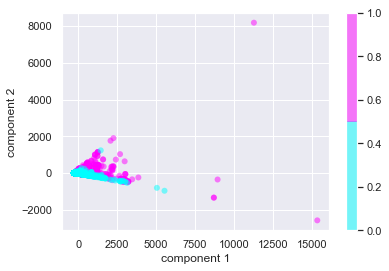

In [6]:
X = spam_df[spam_df.columns.difference(['label'])].values
y = spam_df.label.values
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('cool', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

#### 1. kNN + LOO

Split to test & train sets

In [7]:
X = spam_df[spam_df.columns.difference(['label'])].values
y = spam_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set (X, y):", X_train.shape, y_train.shape)
print("Test set (X, y):", X_test.shape, y_test.shape)

Train set (X, y): (3680, 57) (3680,)
Test set (X, y): (921, 57) (921,)


Select best k with LOO

In [8]:
loo_results = calc_kNN_LOO_iterate_k(X_train, y_train, k_min=1, k_max=10, track_lines=1000)
for k, loo in loo_results:
    print(f"k={k}, loo={loo}")

Lines processed: 1000
Lines processed: 2000
Lines processed: 3000
k=1, loo=0.18315217391304348
k=2, loo=0.19945652173913042
k=3, loo=0.1875
k=4, loo=0.1904891304347826
k=5, loo=0.19619565217391305
k=6, loo=0.20625
k=7, loo=0.20543478260869566
k=8, loo=0.21195652173913043
k=9, loo=0.20380434782608695
k=10, loo=0.20597826086956522


Here we can see that the best k is k=1. Let's calculate accuracy

In [9]:
k=1
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = kNN(X_train, y_train, X_test[i, :], k)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'k={k}, accuracy={score}')

k=1, accuracy=0.8078175895765473


#### 2. RadiusNeighbours + LOO

Find minimum and maximum radius

In [13]:
min_radius, max_radius = get_minmax_distances(X_train)
print(f"Min radius: {min_radius}, max_radius: {max_radius}")

Min radius: 0.014142135623730963, max_radius: 14178.892299136876


Lines processed: 1000
Lines processed: 2000
Lines processed: 3000


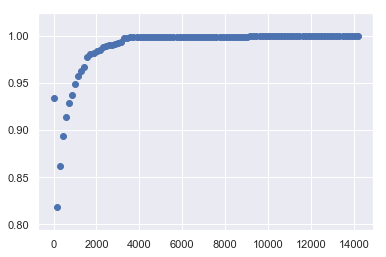

In [14]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=min_radius,
                                    r_max=max_radius, steps=100, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

Lines processed: 1000
Lines processed: 2000
Lines processed: 3000


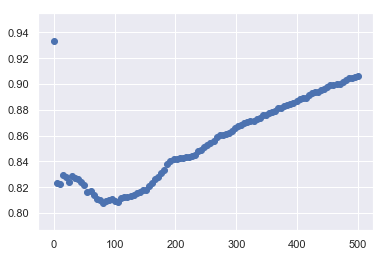

In [17]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=min_radius, r_max=500, steps=100, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

Lines processed: 1000
Lines processed: 2000
Lines processed: 3000


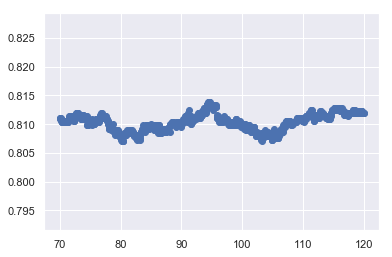

In [18]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=70, r_max=120, steps=1000, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

In [19]:
best_params = sorted(loo_results, key=lambda x: x[1])[0]
print(f"Best radius: {best_params[0]}, loo: {best_params[1]}")

Best radius: 80.26026026026025, loo: 0.8070652173913043


Here we can see, that the best radius is r=80.26. Let's calculate accuracy

In [24]:
radius=80.26
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = RadiusNeighbours(X_train, y_train, X_test[i, :], radius=radius)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'radius={radius}, accuracy={score}')

radius=80.26, accuracy=0.6710097719869706


#### 3. Scaled dataset: KNN + LOO

In [27]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
loo_results = calc_kNN_LOO_iterate_k(X_train_scaled, y_train, k_min=1, k_max=10, track_lines=1000)
for k, loo in loo_results:
    print(f"k={k}, loo={loo}")

Lines processed: 1000
Lines processed: 2000
Lines processed: 3000
k=1, loo=0.09293478260869566
k=2, loo=0.10326086956521739
k=3, loo=0.09918478260869565
k=4, loo=0.10760869565217392
k=5, loo=0.09918478260869565
k=6, loo=0.10217391304347827
k=7, loo=0.10163043478260869
k=8, loo=0.10244565217391305
k=9, loo=0.10135869565217391
k=10, loo=0.10815217391304348


Here we can see that the best k is still k=1. Let's calculate accuracy

In [29]:
k=1
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = kNN(X_train_scaled, y_train, X_test_scaled[i, :], k)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'k={k}, accuracy={score}')

k=1, accuracy=0.8816503800217155


#### 4. Scaled dataset: RadiusNeighbours + LOO

In [30]:
min_radius, max_radius = get_minmax_distances(X_train_scaled)
print(f"Min radius: {min_radius}, max_radius: {max_radius}")

Min radius: 0.00013481007020547416, max_radius: 2.976357922551212


Lines processed: 1000
Lines processed: 2000
Lines processed: 3000


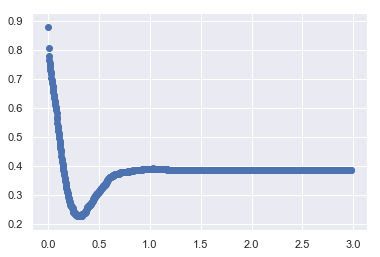

In [31]:
loo_results = calc_RN_LOO_iterate_r(X_train_scaled, y_train, r_min=min_radius, r_max=max_radius,
                                    steps=1000, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

In [32]:
best_params = sorted(loo_results, key=lambda x: x[1])[0]
print(f"Best radius: {best_params[0]}, loo: {best_params[1]}")

Best radius: 0.2861382322906025, loo: 0.22527173913043477


Here we can see, that the best radius is r=0.286. Let's calculate accuracy

In [33]:
radius=0.286
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = RadiusNeighbours(X_train_scaled, y_train, X_test_scaled[i, :], radius=radius)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'radius={radius}, accuracy={score}')

radius=0.286, accuracy=0.751357220412595


### Results for Spam dataset

<table>
    <tr><td></td><td>Params</td><td>LOO</td><td>Accuracy</td></tr>
    <tr><td>KNN</td><td>k=1</td><td>0.183</td><td>0.808</td></tr>
    <tr><td>KNN + Scaled dataset</td><td>k=1</td><td>0.093</td><td>0.882</td></tr>
    <tr><td>RN</td><td>radius=80.26</td><td>0.807</td><td>0.671</td></tr>
    <tr><td>RN + Scaled dataset</td><td>radius=0.286</td><td>0.225</td><td>0.751</td></tr>
</table>

## Cancer

In [35]:
cancer_df = pd.read_csv('./cancer.csv')
cancer_df['int_label'] = cancer_df.label.map({'M':1, 'B':0})
cancer_df['label'] = cancer_df.int_label
cancer_df.drop('int_label', axis=1, inplace=True)
cancer_df.sample(5)

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
157,0,16.84,19.46,108.40,880.2,0.07445,0.07223,0.051500,0.027710,0.1844,...,18.22,28.07,120.30,1032.0,0.08774,0.17100,0.188200,0.08436,0.2527,0.05972
58,0,13.05,19.31,82.61,527.2,0.08060,0.03789,0.000692,0.004167,0.1819,...,14.23,22.25,90.24,624.1,0.10210,0.06191,0.001845,0.01111,0.2439,0.06289
433,1,18.82,21.97,123.70,1110.0,0.10180,0.13890,0.159400,0.087440,0.1943,...,22.66,30.93,145.30,1603.0,0.13900,0.34630,0.391200,0.17080,0.3007,0.08314
526,0,13.46,18.75,87.44,551.1,0.10750,0.11380,0.042010,0.031520,0.1723,...,15.35,25.16,101.90,719.8,0.16240,0.31240,0.265400,0.14270,0.3518,0.08665
15,1,14.54,27.54,96.73,658.8,0.11390,0.15950,0.163900,0.073640,0.2303,...,17.46,37.13,124.10,943.2,0.16780,0.65770,0.702600,0.17120,0.4218,0.13410


Draw data (unnormalized)

Text(0, 0.5, 'component 2')

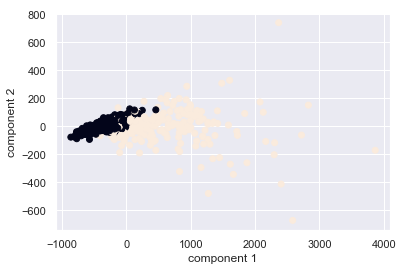

In [36]:
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X)
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y)
plt.xlabel('component 1')
plt.ylabel('component 2')

#### 1. kNN + LOO

Split to test & train sets

In [37]:
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set (X, y):", X_train.shape, y_train.shape)
print("Test set (X, y):", X_test.shape, y_test.shape)

Train set (X, y): (455, 30) (455,)
Test set (X, y): (114, 30) (114,)


Select best k with LOO

In [38]:
loo_results = calc_kNN_LOO_iterate_k(X_train, y_train, k_min=1, k_max=10, track_lines=1000)
for k, loo in loo_results:
    print(f"k={k}, loo={loo}")

k=1, loo=0.09230769230769231
k=2, loo=0.07912087912087912
k=3, loo=0.07252747252747253
k=4, loo=0.07472527472527472
k=5, loo=0.08131868131868132
k=6, loo=0.07472527472527472
k=7, loo=0.07692307692307693
k=8, loo=0.08351648351648351
k=9, loo=0.08131868131868132
k=10, loo=0.08351648351648351


Here we can see that the best k is k=3. Let's calculate accuracy

In [39]:
k=1
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = kNN(X_train, y_train, X_test[i, :], k)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'k={k}, accuracy={score}')

k=1, accuracy=0.9298245614035088


#### 2. RadiusNeighbours + LOO

Find minimum and maximum radius

In [40]:
min_radius, max_radius = get_minmax_distances(X_train)
print(f"Min radius: {min_radius}, max_radius: {max_radius}")

Min radius: 3.8159672659759636, max_radius: 4692.180010811616


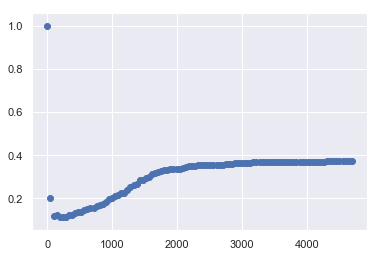

In [41]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=min_radius,
                                    r_max=max_radius, steps=100, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

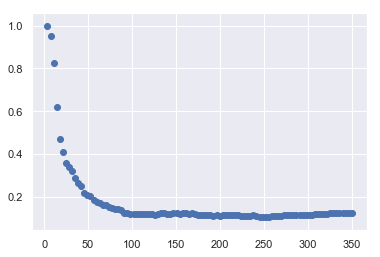

In [42]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=min_radius, r_max=350, steps=100, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

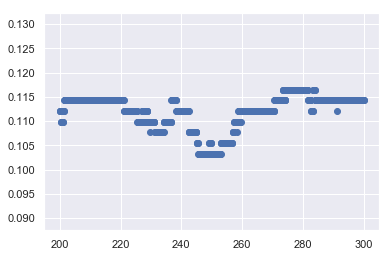

In [43]:
loo_results = calc_RN_LOO_iterate_r(X_train, y_train, r_min=200, r_max=300, steps=1000, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

In [44]:
best_params = sorted(loo_results, key=lambda x: x[1])[0]
print(f"Best radius: {best_params[0]}, loo: {best_params[1]}")

Best radius: 245.54554554554556, loo: 0.10329670329670329


Here we can see, that the best radius is r=245.546. Let's calculate accuracy

In [46]:
radius=245.545
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = RadiusNeighbours(X_train, y_train, X_test[i, :], radius=radius)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'radius={radius}, accuracy={score}')

radius=245.545, accuracy=0.9385964912280702


#### 3. Scaled dataset: KNN + LOO

In [47]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
loo_results = calc_kNN_LOO_iterate_k(X_train_scaled, y_train, k_min=1, k_max=10, track_lines=1000)
for k, loo in loo_results:
    print(f"k={k}, loo={loo}")

k=1, loo=0.03736263736263736
k=2, loo=0.046153846153846156
k=3, loo=0.035164835164835165
k=4, loo=0.035164835164835165
k=5, loo=0.03736263736263736
k=6, loo=0.04395604395604396
k=7, loo=0.03956043956043956
k=8, loo=0.03736263736263736
k=9, loo=0.03296703296703297
k=10, loo=0.03956043956043956


Here we can see that the best k is still k=3. Let's calculate accuracy

In [49]:
k=3
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = kNN(X_train_scaled, y_train, X_test_scaled[i, :], k)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'k={k}, accuracy={score}')

k=3, accuracy=0.9649122807017544


#### 4. Scaled dataset: RadiusNeighbours + LOO

In [50]:
min_radius, max_radius = get_minmax_distances(X_train_scaled)
print(f"Min radius: {min_radius}, max_radius: {max_radius}")

Min radius: 0.16793795317542295, max_radius: 3.5231926343268385


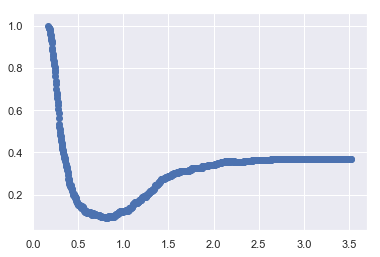

In [51]:
loo_results = calc_RN_LOO_iterate_r(X_train_scaled, y_train, r_min=min_radius, r_max=max_radius,
                                    steps=1000, track_lines=1000)
x_radius = [r for (r, loo) in loo_results]
y_loo = [loo for (r, loo) in loo_results]
plt.scatter(x=x_radius, y=y_loo)

In [52]:
best_params = sorted(loo_results, key=lambda x: x[1])[0]
print(f"Best radius: {best_params[0]}, loo: {best_params[1]}")

Best radius: 0.8094330924145825, loo: 0.09230769230769231


Here we can see, that the best radius is r=0.8094. Let's calculate accuracy

In [59]:
radius=0.8094
predicted_labels = []
for i in range(y_test.shape[0]):
    _, label = RadiusNeighbours(X_train_scaled, y_train, X_test_scaled[i, :], radius=radius)
    predicted_labels.append(label)
score = accuracy_score(y_test, predicted_labels)
print(f'radius={radius}, accuracy={score}')

radius=0.8094, accuracy=0.8947368421052632


### Results for Cancer dataset

<table>
    <tr><td></td><td>Params</td><td>LOO</td><td>Accuracy</td></tr>
    <tr><td>KNN</td><td>k=3</td><td>0.073</td><td>0.93</td></tr>
    <tr><td>KNN + Scaled dataset</td><td>k=3</td><td>0.035</td><td>0.965</td></tr>
    <tr><td>RN</td><td>radius=245.545</td><td>0.103</td><td>0.939</td></tr>
    <tr><td>RN + Scaled dataset</td><td>radius=0.8094</td><td>0.092</td><td>0.895</td></tr>
</table>